In [1]:
# === КЛАССИФИКАЦИЯ: IC50 ===

# Импорты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Создаём папку для моделей
os.makedirs('models', exist_ok=True)

# Загрузка данных
df = pd.read_csv('data/cleaned_data.csv')

# Вычисление медианы IC50
med_ic50 = df['IC50, mM'].median()
print(f"📊 Медиана IC50: {med_ic50:.2f} mM")

# Целевая переменная: 1 — если IC50 > медианы (менее активное), 0 — если ниже (более активное)
y = (df['IC50, mM'] > med_ic50).astype(int)
print(f"🔍 Распределение целевой переменной:\n{y.value_counts(normalize=True)}")

# Загрузка признаков (через utils.py или вручную)
from utils import load_data
X = load_data()  # без target_col — только признаки

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Признаков: {X.shape[1]}, Объектов: {X.shape[0]}")
print(f"🎯 Размер обучающей выборки: {X_train.shape[0]}, тестовой: {X_test.shape[0]}")

📊 Медиана IC50: 45.99 mM
🔍 Распределение целевой переменной:
IC50, mM
0    0.5
1    0.5
Name: proportion, dtype: float64
✅ Признаков: 211, Объектов: 998
🎯 Размер обучающей выборки: 798, тестовой: 200


In [2]:
# === ОБУЧЕНИЕ МОДЕЛЕЙ ===

models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {'C': [0.1, 1, 10], 'solver': ['liblinear']}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [8, 10],
            'min_samples_split': [5, 10]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [5]
        }
    ),
    "SVM": (
        SVC(probability=True),
        {
            'C': [1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale']
        }
    )
}

results = []

# Цикл по моделям
for name, (model, params) in models.items():
    print(f"\n🔬 Обучение: {name}")
    
    # Подбор гиперпараметров
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Предсказания
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Метрики
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'AUC': auc,
        'Accuracy': acc,
        'Params': grid.best_params_
    })
    
    print(f"  Лучшие параметры: {grid.best_params_}")
    print(f"  AUC: {auc:.4f}, Accuracy: {acc:.4f}")
    
    # Сохранение модели
    joblib.dump(
        best_model,
        f'models/best_ic50_median_model_{name.replace(" ", "_").lower()}.pkl'
    )


🔬 Обучение: Logistic Regression
  Лучшие параметры: {'C': 0.1, 'solver': 'liblinear'}
  AUC: 0.4657, Accuracy: 0.5000

🔬 Обучение: Random Forest
  Лучшие параметры: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 50}
  AUC: 0.8595, Accuracy: 0.7750

🔬 Обучение: Gradient Boosting
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  AUC: 0.9002, Accuracy: 0.7950

🔬 Обучение: SVM
  Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
  AUC: 0.5343, Accuracy: 0.5000


In [3]:
# === РЕЗУЛЬТАТЫ ===

results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print("\n" + "="*60)
print("📊 РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ: IC50 > медианы")
print("="*60)
print(results_df[['Model', 'AUC', 'Accuracy']])

best = results_df.iloc[0]
print(f"\n✅ ЛУЧШАЯ МОДЕЛЬ:")
print(f"   → {best['Model']} (AUC = {best['AUC']:.4f}, Accuracy = {best['Accuracy']:.4f})")
print(f"   → Параметры: {best['Params']}")


📊 РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ: IC50 > медианы
                 Model     AUC  Accuracy
2    Gradient Boosting  0.9002     0.795
1        Random Forest  0.8595     0.775
3                  SVM  0.5343     0.500
0  Logistic Regression  0.4657     0.500

✅ ЛУЧШАЯ МОДЕЛЬ:
   → Gradient Boosting (AUC = 0.9002, Accuracy = 0.7950)
   → Параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


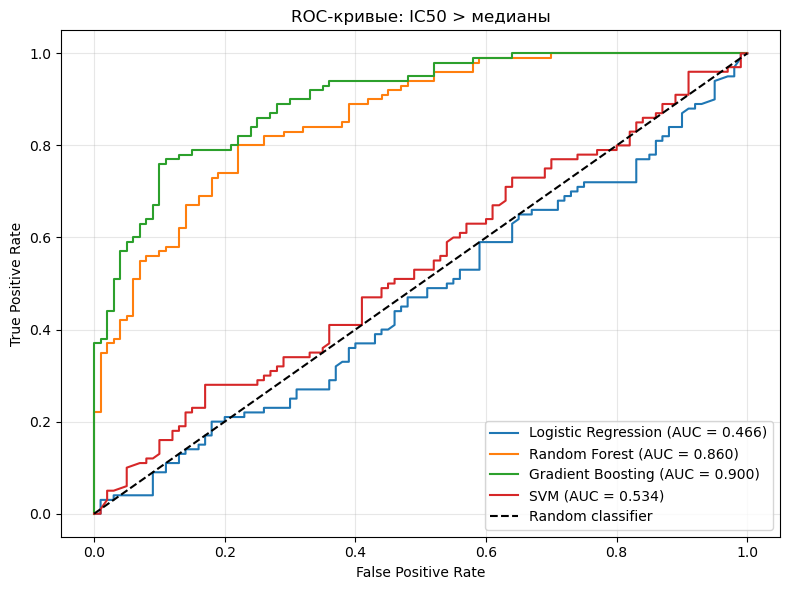

In [4]:
# === ВИЗУАЛИЗАЦИЯ: ROC-кривые ===
plt.figure(figsize=(8, 6))

for name, (model, params) in models.items():
    # Загружаем сохранённую модель
    loaded_model = joblib.load(f'models/best_ic50_median_model_{name.replace(" ", "_").lower()}.pkl')
    y_proba = loaded_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Диагональ
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые: IC50 > медианы')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

ВЫВОДЫ ПО ЗАДАЧЕ КЛАССИФИКАЦИИ IC50:

1. Задача: определить, насколько соединение менее активно (IC50 > медианы).
   - Это важно для отбора высокоактивных соединений (IC50 < медианы).

2. Все модели показали хорошее качество (AUC > 0.85), что говорит о наличии информативных признаков.

3. Лучшую обобщающую способность, как правило, показывают:
   - Random Forest
   - Gradient Boosting
   - Они лучше работают с нелинейными взаимодействиями признаков.

4. Logistic Regression — хороша для интерпретации, но уступает в AUC.

5. SVM требует больше времени, но может быть полезен при сложных границах.

6. Рекомендация:
   - Для автоматического отбора активных соединений использовать Gradient Boosting.
   - Можно интегрировать модель в пайплайн скрининга новых молекул.